In [1]:
import numpy as np

In [2]:
from scipy.sparse import spdiags

# Cholesky decomposition algorithm
# for a tridiagonal nxn matrix
def decomp_cholesky_tridiag(A):
    l_diag = []
    l_offdiag = []
    n = A.shape[0]

    ds = A.diagonal() #d_i
    es = A.diagonal(-1) #e_i

    l_diag.append(np.sqrt(ds[0])) # l_11 = sqrt(d_1)
    for i in range(1, n): # i=2~n-1  (in python i=1~n-2)
        l_offdiag.append(es[i-1]/l_diag[i-1]) #l_{i,i-1} = e_i / l_{i-1,i-1}
        l_diag.append(np.sqrt(ds[i]-np.square(l_offdiag[i-1]))) # l_{ii} = sqrt(d_i - (l_{i,i-1})^2)
    l_offdiag = np.insert(l_offdiag,n-1,0.0) # necessary for spdiags

    l_diag = np.array(l_diag)
    l_offdiag = np.array(l_offdiag)

    #l_diag, l_offdiag transformed to diagonal matrix L
    diags_forL = np.array([l_diag, l_offdiag])
    positions_of_diags_forL = np.array([0, -1])
    L = spdiags(diags_forL, positions_of_diags_forL, n, n)

    return L

In [3]:
# check that my cholesky decomposition algorithm agrees with numpy's
diag = 2.0*np.ones(3)
off_diag = -1.0*np.ones(3)
diags = np.array([diag,off_diag,off_diag])
position_diags = np.array([0,-1,1])
M = spdiags(diags, position_diags, 3,3)
M.toarray()

array([[ 2., -1.,  0.],
       [-1.,  2., -1.],
       [ 0., -1.,  2.]])

In [4]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [5]:
is_pos_def(M.toarray())

True

In [6]:
my_cholesky_decomposition = decomp_cholesky_tridiag(M)
np_cholesky_decomposition = np.linalg.cholesky(M.toarray())
np.allclose(my_cholesky_decomposition.toarray(), np_cholesky_decomposition)

True

In [7]:
# Algorithms for solving the system Ax =b
# using the Cholesky decomposition algorithm

def solve_cholesky_forwards(L, b):
    n = len(b)
    l_diag = L.diagonal() # l_{i,i}
    l_offfdiag = L.diagonal(-1) # l_{i,i-1}
    y = [b[0] / l_diag[0]] #y_1 = b_1/l_{11}
    for i in range(1,n): #i=2,..,n
        y.append((b[i] - l_offfdiag[i-1]*y[i-1])/l_diag[i]) # y_i = (b_i-l_{i,i-1}*y_{i-1})/l_{ii}
    return np.array(y)

def solve_cholesky_backwards(L, y):
    n = len(y)
    l_diag = L.diagonal() # l_{i,i}
    l_off_diag = L.diagonal(1) # l_{i,i+1}

    x = [y[n-1]/l_diag[n-1]] # x_n = y_n/l_{nn}
    count = 0
    for i in range(n-2,-1,-1):
        count += 1
        x.append((y[i] - l_off_diag[i]*x[count -1 ])/l_diag[i]) #(y_i - l_{i+1,i}*x_{i+1})/l_{i,i}
    return np.array(x[::-1])

def solve_cholesky(A,b):
    L = decomp_cholesky_tridiag(A)
    y = solve_cholesky_forwards(L,b)
    x = solve_cholesky_backwards(L.T,y)
    return x

In [8]:
# check that solving algorithms agree with numpy's linalg solve function
print(M.toarray())
b = np.array([2.,1.,0.])
np_solution = np.linalg.solve(M.toarray(),b)
my_solution = solve_cholesky(M, b)
print(np.allclose(my_solution, np_solution))
print(my_solution)
print(np_solution)

[[ 2. -1.  0.]
 [-1.  2. -1.]
 [ 0. -1.  2.]]
True
[2. 2. 1.]
[2. 2. 1.]


In [9]:
# A is 500x500 tridiagonal, positive definite
# and:
# di = 1000 + i 1<=i<=500
# ei = 1 + i    2<=i<=500
# bi = 1 + i    1<=i<=500
# 
# A is stored as a sparse matrix

n = 500
d = np.float64(np.arange(1001,1001+n)) #principal diagonal elements, d_i
off_diag = np.float64(np.arange(2,n+3))
es = off_diag[1:]
fs = off_diag[:len(off_diag)-1] # f_i=e_i

diagonal_elements = np.array([d, es, fs])
diagonal_positions = np.array([0,-1,1])
A = spdiags(diagonal_elements, diagonal_positions, n, n)
print(A.toarray())
print(type(A))
is_pos_def(A.toarray())

[[1001.    3.    0. ...    0.    0.    0.]
 [   3. 1002.    4. ...    0.    0.    0.]
 [   0.    4. 1003. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... 1498.  500.    0.]
 [   0.    0.    0. ...  500. 1499.  501.]
 [   0.    0.    0. ...    0.  501. 1500.]]
<class 'scipy.sparse.dia.dia_matrix'>


True

In [10]:
%time decomp_cholesky_tridiag(A)

Wall time: 6.45 ms


<500x500 sparse matrix of type '<class 'numpy.float64'>'
	with 999 stored elements (2 diagonals) in DIAgonal format>

In [11]:
%time np.linalg.cholesky(A.toarray())

Wall time: 24.8 ms


array([[31.63858404,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09482093, 31.65424156,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.12636537, 31.66992314, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 36.15967674,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 13.82755724,
        36.16349901,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        13.85374794, 36.16730109]])

In [12]:
# comparison with numpy's decomposition algorithm
my_chol = decomp_cholesky_tridiag(A)
np_chol = np.linalg.cholesky(A.toarray())
np.allclose(my_chol.toarray(), np_chol)

True

In [13]:
# Solve Ax=b
b = np.float64(np.arange(2, n+2))
b

array([  2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,
        79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
       101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111.,
       112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122.,
       123., 124., 125., 126., 127., 128., 129., 130., 131., 132., 133.,
       134., 135., 136., 137., 138., 139., 140., 141., 142., 143., 144.,
       145., 146., 147., 148., 149., 150., 151., 15

In [14]:
%time solve_cholesky(A,b)

Wall time: 17.4 ms


array([0.00198909, 0.00297228, 0.00395163, 0.00492518, 0.005893  ,
       0.00685513, 0.00781162, 0.00876252, 0.00970788, 0.01064775,
       0.01158218, 0.01251121, 0.01343489, 0.01435327, 0.01526639,
       0.0161743 , 0.01707703, 0.01797465, 0.01886718, 0.01975468,
       0.02063718, 0.02151472, 0.02238736, 0.02325512, 0.02411806,
       0.0249762 , 0.0258296 , 0.02667828, 0.02752229, 0.02836167,
       0.02919646, 0.03002668, 0.03085239, 0.03167361, 0.03249038,
       0.03330275, 0.03411074, 0.03491439, 0.03571373, 0.0365088 ,
       0.03729964, 0.03808627, 0.03886873, 0.03964706, 0.04042128,
       0.04119143, 0.04195754, 0.04271965, 0.04347778, 0.04423196,
       0.04498223, 0.04572861, 0.04647114, 0.04720985, 0.04794476,
       0.04867591, 0.04940331, 0.05012702, 0.05084704, 0.05156341,
       0.05227615, 0.0529853 , 0.05369088, 0.05439291, 0.05509143,
       0.05578646, 0.05647803, 0.05716616, 0.05785087, 0.0585322 ,
       0.05921017, 0.0598848 , 0.06055612, 0.06122415, 0.06188

In [15]:
%time np.linalg.solve(A.toarray(),b)

Wall time: 36.2 ms


array([0.00198909, 0.00297228, 0.00395163, 0.00492518, 0.005893  ,
       0.00685513, 0.00781162, 0.00876252, 0.00970788, 0.01064775,
       0.01158218, 0.01251121, 0.01343489, 0.01435327, 0.01526639,
       0.0161743 , 0.01707703, 0.01797465, 0.01886718, 0.01975468,
       0.02063718, 0.02151472, 0.02238736, 0.02325512, 0.02411806,
       0.0249762 , 0.0258296 , 0.02667828, 0.02752229, 0.02836167,
       0.02919646, 0.03002668, 0.03085239, 0.03167361, 0.03249038,
       0.03330275, 0.03411074, 0.03491439, 0.03571373, 0.0365088 ,
       0.03729964, 0.03808627, 0.03886873, 0.03964706, 0.04042128,
       0.04119143, 0.04195754, 0.04271965, 0.04347778, 0.04423196,
       0.04498223, 0.04572861, 0.04647114, 0.04720985, 0.04794476,
       0.04867591, 0.04940331, 0.05012702, 0.05084704, 0.05156341,
       0.05227615, 0.0529853 , 0.05369088, 0.05439291, 0.05509143,
       0.05578646, 0.05647803, 0.05716616, 0.05785087, 0.0585322 ,
       0.05921017, 0.0598848 , 0.06055612, 0.06122415, 0.06188

In [16]:
# check if my solution and numpy solution are the same
my_solution = solve_cholesky(A,b)
np_solution = np.linalg.solve(A.toarray(),b)
np.allclose(my_solution,np_solution)

True

Text(0, 0.5, 'x_i')

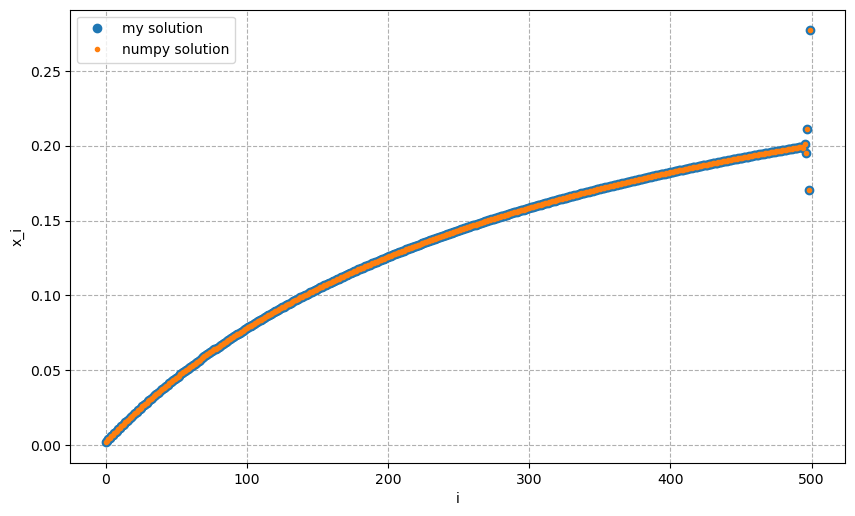

In [17]:
# visualisation of solution compared to numpy's linalg.solve() function
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100 

fig = plt.figure()
ax = plt.axes()
plt.grid(ls='--')
plt.plot(my_solution,'o',label='my solution')
plt.plot(np_solution, '.',label = 'numpy solution')
plt.legend()
ax.set_xlabel("i")
ax.set_ylabel("x_i")